Loading original CLIP model...
Selected classes: ['christmas_tree_farm', 'baseball_field', 'harbor', 'freeway', 'forest', 'closed_road', 'chaparral', 'oil_gas_field', 'overpass', 'runway', 'tennis_court', 'basketball_court', 'intersection', 'football_field', 'transformer_station', 'airplane', 'railway', 'solar_panel', 'wastewater_treatment_plant', 'golf_course']
Total images to process: 1000
Extracted features shape: (1000, 512)


/tmp/ipykernel_659910/3671369884.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap_name, len(class_names))


Saved t-SNE plot to patternnet_tsne_vis.png


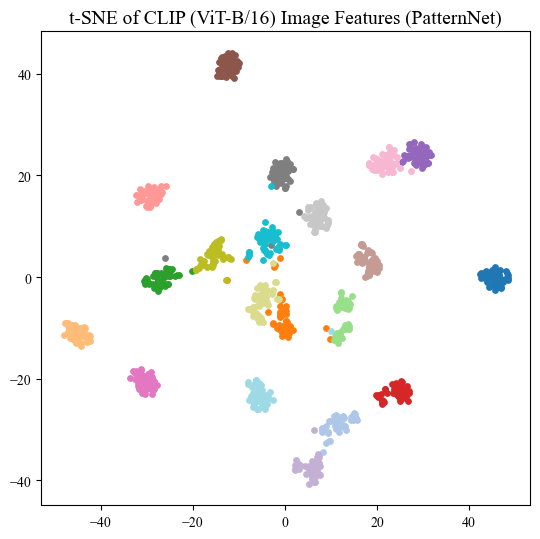

In [4]:
# AID Dataset t-SNE Visualization with Original CLIP Features

import os
import torch
from clip import clip
from dassl.engine import build_trainer
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import matplotlib
matplotlib.rcParams["font.family"] = "Times New Roman"

def extract_features_and_labels(class_mapping, model, preprocess, device):
    """
    从给定的图像路径字典中提取特征和标签。
    """
    all_features = []
    all_labels = []

    # 类别按字母排序保证图例顺序固定
    sorted_classes = sorted(class_mapping.keys())
    label_to_idx = {cls: idx for idx, cls in enumerate(sorted_classes)}

    with torch.no_grad():
        for cls in sorted_classes:
            for path in class_mapping[cls]:
                try:
                    image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
                    feature = model.encode_image(image).squeeze()
                    feature = feature / feature.norm()
                    all_features.append(feature.cpu().numpy())
                    all_labels.append(label_to_idx[cls])
                except Exception as e:
                    print(f"Error loading {path}: {e}")

    return np.array(all_features), np.array(all_labels), sorted_classes


def plot_tsne(features, labels, class_names, output_file, legend_loc="upper right",
              cmap_name="tab20", dataset_name="Dataset"):
    """
    使用 t-SNE 对特征降维并绘制散点图。
    """
    plt.rcParams["font.family"] = "Times New Roman"

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(5.5, 5.5))

    # 获取调色板
    try:
        colors = plt.cm.get_cmap(cmap_name, len(class_names))
    except ValueError:
        print(f"Warning: colormap '{cmap_name}' not found, fallback to 'hsv'")
        colors = plt.cm.get_cmap("hsv", len(class_names))

    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(
            reduced[idx, 0],
            reduced[idx, 1],
            color=colors(label),
            label=class_names[label],
            s=15
        )

    # plt.legend(fontsize=10, loc=legend_loc)
    plt.title(f"t-SNE of CLIP (ViT-B/16) Image Features ({dataset_name})", fontsize=14)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    print(f"Saved t-SNE plot to {output_file}")


def load_aid_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    """
    为 AID 数据集加载图像路径映射。
    AID 数据集结构: image_root/class_name/*.jpg
    """
    class_dirs = [d for d in sorted(os.listdir(image_root)) 
                  if os.path.isdir(os.path.join(image_root, d))]
    random.seed(seed)
    selected_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    mapping = {}
    for cls in selected_classes:
        cls_dir = os.path.join(image_root, cls)
        all_images = [os.path.join(cls_dir, f)
                      for f in os.listdir(cls_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff"))]
        random.seed(seed)
        selected_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        mapping[cls] = selected_images
    
    return mapping

def load_patternnet_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    """
    为 PatternNet 数据集加载图像路径映射。
    PatternNet 数据集结构: image_root/class_name/*.jpg
    """
    class_dirs = [d for d in sorted(os.listdir(image_root)) 
                  if os.path.isdir(os.path.join(image_root, d))]
    random.seed(seed)
    selected_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    mapping = {}
    for cls in selected_classes:
        cls_dir = os.path.join(image_root, cls)
        all_images = [os.path.join(cls_dir, f)
                      for f in os.listdir(cls_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff"))]
        random.seed(seed)
        selected_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        mapping[cls] = selected_images
    
    return mapping


def load_food101_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    class_dirs = sorted(os.listdir(image_root))
    random.seed(seed)
    selected_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    mapping = {}
    for cls in selected_classes:
        cls_dir = os.path.join(image_root, cls)
        all_images = [os.path.join(cls_dir, f)
                      for f in os.listdir(cls_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        random.seed(seed)
        selected_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        mapping[cls] = selected_images
    return mapping


def load_fgvc_mapping(label_file, image_root, num_classes=10, num_images_per_class=20, seed=42):
    mapping = defaultdict(list)
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            img_name, cls = parts
            full_path = os.path.join(image_root, img_name + ".jpg")
            if os.path.isfile(full_path):
                mapping[cls].append(full_path)

    all_classes = sorted(mapping.keys())
    random.seed(seed)
    selected_classes = random.sample(all_classes, min(num_classes, len(all_classes)))

    filtered_mapping = {}
    for cls in selected_classes:
        random.seed(seed)
        selected_images = random.sample(mapping[cls], min(num_images_per_class, len(mapping[cls])))
        filtered_mapping[cls] = selected_images

    return filtered_mapping


def load_imagenet_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    class_dirs = [d for d in sorted(os.listdir(image_root)) if os.path.isdir(os.path.join(image_root, d))]
    random.seed(seed)
    selected_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    mapping = {}
    for cls in selected_classes:
        cls_dir = os.path.join(image_root, cls)
        all_images = [os.path.join(cls_dir, f)
                      for f in os.listdir(cls_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        random.seed(seed)
        selected_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        mapping[cls] = selected_images
    return mapping


def load_imagenet_classnames(classnames_file):
    """
    读取 ImageNet 类别映射文件，返回 {WordNet ID: 类别名} 字典。
    """
    id2name = {}
    with open(classnames_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) == 2:
                wnid, name = parts
                id2name[wnid] = name
    return id2name


def load_clip_to_cpu():
    """加载原始CLIP模型到CPU"""
    backbone_name = "ViT-B/16"  # 使用ViT-B/16作为backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")
    
    # 设计原始CLIP的参数
    design_details = {"trainer": 'CoOp',
                      "vision_depth": 0,
                      "language_depth": 0, "vision_ctx": 0,
                      "language_ctx": 0}
    
    model = clip.build_model(state_dict or model.state_dict(), design_details)

    return model


# 加载原始CLIP模型
print("Loading original CLIP model...")
model = load_clip_to_cpu()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# 获取预处理函数
preprocess = clip._transform(model.visual.input_resolution)

DATASET_NAME_MAP = {
    "aid": "AID",
    "food101": "Food-101",
    "fgvc": "FGVC-Aircraft",
    "imagenet": "ImageNet",
    "patternnet": "PatternNet"
}

# 配置参数
dataset_type = "patternnet"  # 可选: "aid", "food101", "fgvc", "imagenet"
data_root = "/mnt/hdd/DATA/PatternNet/images"  # 替换为你的ImageNet训练集路径
num_classes = 20
num_images_per_class = 50
output_file = f"{dataset_type}_tsne_vis.png"
seed = 42
legend_loc = "upper right"
cmap = "tab20"
label_file = "/mnt/hdd/DATA/imagenet/classnames.txt"  # 需要提供ImageNet类别名称文件

dataset_name = DATASET_NAME_MAP.get(dataset_type, dataset_type)

# 根据数据集类型加载映射
if dataset_type == "aid":
    mapping = load_aid_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "food101":
    mapping = load_food101_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "patternnet":
    mapping = load_patternnet_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "fgvc":
    if label_file is None:
        raise ValueError("FGVC dataset requires label_file.")
    mapping = load_fgvc_mapping(label_file, data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "imagenet":
    mapping = load_imagenet_mapping(data_root, num_classes, num_images_per_class, seed)
    if label_file:  # 用 classnames.txt 替换 WordNet ID 为自然语言名称
        id2name = load_imagenet_classnames(label_file)
        mapping_named = {}
        for cls_id, imgs in mapping.items():
            cls_name = id2name.get(cls_id, cls_id)  # 找不到就保留 ID
            mapping_named[cls_name] = imgs
        mapping = mapping_named
else:
    raise ValueError(f"Unsupported dataset type: {dataset_type}")

print(f"Selected classes: {list(mapping.keys())}")
print(f"Total images to process: {sum(len(imgs) for imgs in mapping.values())}")

# 提取特征和标签
feats, labels, class_names = extract_features_and_labels(mapping, model, preprocess, device)
print(f"Extracted features shape: {feats.shape}")

# 绘制t-SNE图
plot_tsne(
    feats, labels, class_names,
    output_file,
    legend_loc=legend_loc,
    cmap_name=cmap,
    dataset_name=dataset_name
)

# 显示图像
plt.show()



Selected classes: ['Commercial', 'Playground', 'Parking', 'Bridge', 'Forest', 'Pond', 'Mountain', 'Port', 'StorageTanks', 'BaseballField', 'School', 'Airport', 'River', 'DenseResidential', 'Viaduct', 'Beach', 'SparseResidential', 'Stadium', 'Park', 'Meadow']
Total images to process: 1000
Extracted features shape: (1000, 512)


/tmp/ipykernel_2928753/1589853792.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap_name, len(class_names))


Saved t-SNE plot to aid_tsne_vis_3.png


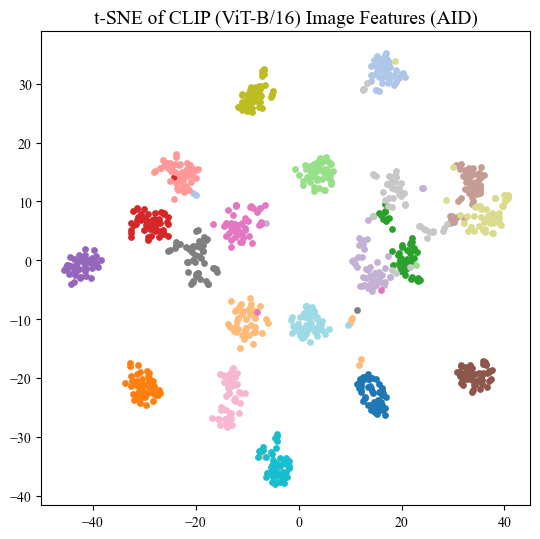

In [9]:
# 配置参数
dataset_type = "aid"  # 可选: "aid", "food101", "fgvc", "imagenet"
data_root = "/mnt/hdd/DATA/AID/AID_dataset" 
seed = 3
num_classes = 20
num_images_per_class = 50
output_file = f"{dataset_type}_tsne_vis_{seed}.png"
legend_loc = "upper right"
cmap = "tab20"
label_file = None

dataset_name = DATASET_NAME_MAP.get(dataset_type, dataset_type)

# 根据数据集类型加载映射
if dataset_type == "aid":
    mapping = load_aid_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "food101":
    mapping = load_food101_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "fgvc":
    if label_file is None:
        raise ValueError("FGVC dataset requires label_file.")
    mapping = load_fgvc_mapping(label_file, data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "imagenet":
    mapping = load_imagenet_mapping(data_root, num_classes, num_images_per_class, seed)
    if label_file:  # 用 classnames.txt 替换 WordNet ID 为自然语言名称
        id2name = load_imagenet_classnames(label_file)
        mapping_named = {}
        for cls_id, imgs in mapping.items():
            cls_name = id2name.get(cls_id, cls_id)  # 找不到就保留 ID
            mapping_named[cls_name] = imgs
        mapping = mapping_named
else:
    raise ValueError(f"Unsupported dataset type: {dataset_type}")

print(f"Selected classes: {list(mapping.keys())}")
print(f"Total images to process: {sum(len(imgs) for imgs in mapping.values())}")

# 提取特征和标签
feats, labels, class_names = extract_features_and_labels(mapping, model, preprocess, device)
print(f"Extracted features shape: {feats.shape}")

# 绘制t-SNE图
plot_tsne(
    feats, labels, class_names,
    output_file,
    legend_loc=legend_loc,
    cmap_name=cmap,
    dataset_name=dataset_name
)

# 显示图像
plt.show()

In [ ]:
# # 配置参数
# dataset_type = "imagenet"  # 可选: "aid", "food101", "fgvc", "imagenet"
# data_root = "/mnt/hdd/DATA/imagenet/images/train"  # 替换为你的ImageNet训练集路径
# num_classes = 20
# num_images_per_class = 50
# output_file = f"{dataset_type}_tsne_vis.png"
# seed = 29
# legend_loc = "upper right"
# cmap = "tab20"
# label_file = "/mnt/hdd/DATA/imagenet/classnames.txt"  # 需要提供ImageNet类别名称文件

# dataset_name = DATASET_NAME_MAP.get(dataset_type, dataset_type)

# # 根据数据集类型加载映射
# if dataset_type == "aid":
#     mapping = load_aid_mapping(data_root, num_classes, num_images_per_class, seed)
# elif dataset_type == "food101":
#     mapping = load_food101_mapping(data_root, num_classes, num_images_per_class, seed)
# elif dataset_type == "fgvc":
#     if label_file is None:
#         raise ValueError("FGVC dataset requires label_file.")
#     mapping = load_fgvc_mapping(label_file, data_root, num_classes, num_images_per_class, seed)
# elif dataset_type == "imagenet":
#     mapping = load_imagenet_mapping(data_root, num_classes, num_images_per_class, seed)
#     if label_file:  # 用 classnames.txt 替换 WordNet ID 为自然语言名称
#         id2name = load_imagenet_classnames(label_file)
#         mapping_named = {}
#         for cls_id, imgs in mapping.items():
#             cls_name = id2name.get(cls_id, cls_id)  # 找不到就保留 ID
#             mapping_named[cls_name] = imgs
#         mapping = mapping_named
# else:
#     raise ValueError(f"Unsupported dataset type: {dataset_type}")

# print(f"Selected classes: {list(mapping.keys())}")
# print(f"Total images to process: {sum(len(imgs) for imgs in mapping.values())}")

# # 提取特征和标签
# feats, labels, class_names = extract_features_and_labels(mapping, model, preprocess, device)
# print(f"Extracted features shape: {feats.shape}")

# # 绘制t-SNE图
# plot_tsne(
#     feats, labels, class_names,
#     output_file,
#     legend_loc=legend_loc,
#     cmap_name=cmap,
#     dataset_name=dataset_name
# )

# # 显示图像
# plt.show()

# 配置参数
dataset_type = "patternnet"  # 可选: "aid", "food101", "fgvc", "imagenet"
data_root = "/mnt/hdd/DATA/PatternNet/images" 
seed = 42
num_classes = 20
num_images_per_class = 50
output_file = f"{dataset_type}_tsne_vis.png"
legend_loc = "upper right"
cmap = "tab20"
label_file = None

dataset_name = DATASET_NAME_MAP.get(dataset_type, dataset_type)

# 根据数据集类型加载映射
if dataset_type == "aid":
    mapping = load_aid_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "patternnet":
    mapping = load_patternnet_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "food101":
    mapping = load_food101_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "fgvc":
    if label_file is None:
        raise ValueError("FGVC dataset requires label_file.")
    mapping = load_fgvc_mapping(label_file, data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "imagenet":
    mapping = load_imagenet_mapping(data_root, num_classes, num_images_per_class, seed)
    if label_file:  # 用 classnames.txt 替换 WordNet ID 为自然语言名称
        id2name = load_imagenet_classnames(label_file)
        mapping_named = {}
        for cls_id, imgs in mapping.items():
            cls_name = id2name.get(cls_id, cls_id)  # 找不到就保留 ID
            mapping_named[cls_name] = imgs
        mapping = mapping_named
else:
    raise ValueError(f"Unsupported dataset type: {dataset_type}")

print(f"Selected classes: {list(mapping.keys())}")
print(f"Total images to process: {sum(len(imgs) for imgs in mapping.values())}")

# 提取特征和标签
feats, labels, class_names = extract_features_and_labels(mapping, model, preprocess, device)
print(f"Extracted features shape: {feats.shape}")

# 绘制t-SNE图
plot_tsne(
    feats, labels, class_names,
    output_file,
    legend_loc=legend_loc,
    cmap_name=cmap,
    dataset_name=dataset_name
)

# 显示图像
plt.show()

NameError: name 'DATASET_NAME_MAP' is not defined

Selected classes: ['Resort', 'Industrial', 'Square', 'Playground', 'Center', 'Church', 'SparseResidential', 'School', 'River', 'BaseballField', 'Bridge', 'Desert', 'Airport', 'MediumResidential', 'Park', 'Meadow', 'Forest', 'Farmland', 'BareLand', 'Parking']
Total images to process: 400
Extracted features shape: (400, 512)


/tmp/ipykernel_1454004/293328529.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap_name, len(class_names))


Saved t-SNE plot to aid_tsne_vis.png


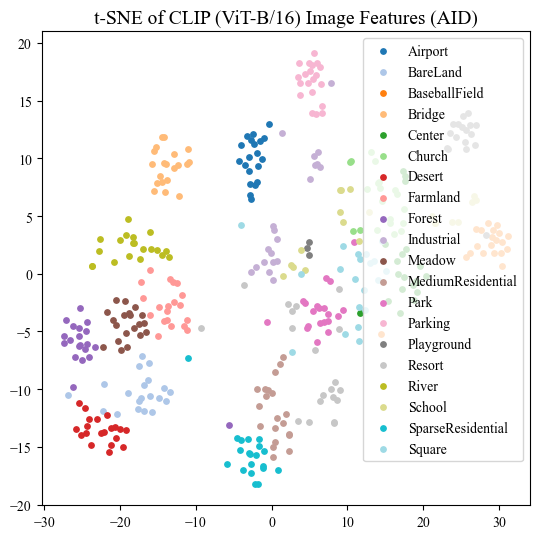

In [ ]:
# 配置参数
dataset_type = "aid"  # 可选: "aid", "food101", "fgvc", "imagenet"
data_root = "/mnt/hdd/DATA/AID/AID_dataset" 
num_classes = 20
num_images_per_class = 20
output_file = f"{dataset_type}_tsne_vis.png"
seed = 24
legend_loc = "upper right"
cmap = "tab20"
label_file = None

dataset_name = DATASET_NAME_MAP.get(dataset_type, dataset_type)

# 根据数据集类型加载映射
if dataset_type == "aid":
    mapping = load_aid_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "food101":
    mapping = load_food101_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "fgvc":
    if label_file is None:
        raise ValueError("FGVC dataset requires label_file.")
    mapping = load_fgvc_mapping(label_file, data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "imagenet":
    mapping = load_imagenet_mapping(data_root, num_classes, num_images_per_class, seed)
    if label_file:  # 用 classnames.txt 替换 WordNet ID 为自然语言名称
        id2name = load_imagenet_classnames(label_file)
        mapping_named = {}
        for cls_id, imgs in mapping.items():
            cls_name = id2name.get(cls_id, cls_id)  # 找不到就保留 ID
            mapping_named[cls_name] = imgs
        mapping = mapping_named
else:
    raise ValueError(f"Unsupported dataset type: {dataset_type}")

print(f"Selected classes: {list(mapping.keys())}")
print(f"Total images to process: {sum(len(imgs) for imgs in mapping.values())}")

# 提取特征和标签
feats, labels, class_names = extract_features_and_labels(mapping, model, preprocess, device)
print(f"Extracted features shape: {feats.shape}")

# 绘制t-SNE图
plot_tsne(
    feats, labels, class_names,
    output_file,
    legend_loc=legend_loc,
    cmap_name=cmap,
    dataset_name=dataset_name
)

# 显示图像
plt.show()

Loading original CLIP model...
Selected classes: ['prince of wales feathers', 'barbeton daisy', 'watercress', 'bougainvillea', 'peruvian lily', 'purple coneflower', 'azalea', 'columbine', 'thorn apple', 'spring crocus', 'common dandelion', 'lotus', 'canterbury bells', 'osteospermum', 'frangipani', 'sweet william', 'primula', 'spear thistle', 'toad lily', 'monkshood']
Total images to process: 400
Extracted features shape: (400, 512)


/tmp/ipykernel_2054171/2068370855.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap_name, len(class_names))


Saved t-SNE plot to flowers_tsne_vis.png


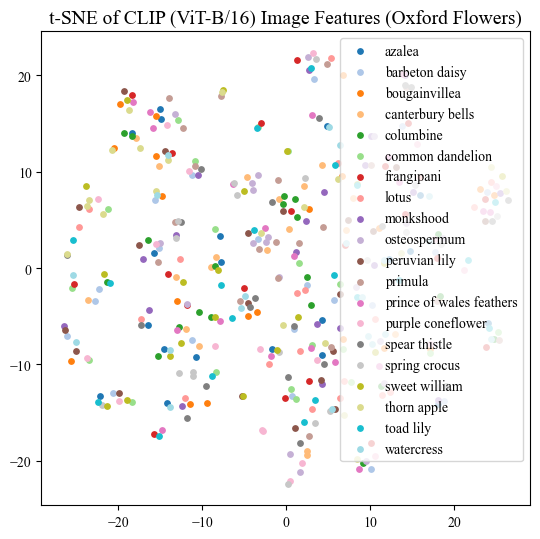

In [ ]:
# Oxford Flowers Dataset t-SNE Visualization with Original CLIP Features

import os
import torch
from clip import clip
from dassl.engine import build_trainer
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import matplotlib
import json
import scipy.io as sio
matplotlib.rcParams["font.family"] = "Times New Roman"

def extract_features_and_labels(class_mapping, model, preprocess, device):
    """
    从给定的图像路径字典中提取特征和标签。
    """
    all_features = []
    all_labels = []

    # 类别按字母排序保证图例顺序固定
    sorted_classes = sorted(class_mapping.keys())
    label_to_idx = {cls: idx for idx, cls in enumerate(sorted_classes)}

    with torch.no_grad():
        for cls in sorted_classes:
            for path in class_mapping[cls]:
                try:
                    image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
                    feature = model.encode_image(image).squeeze()
                    feature = feature / feature.norm()
                    all_features.append(feature.cpu().numpy())
                    all_labels.append(label_to_idx[cls])
                except Exception as e:
                    print(f"Error loading {path}: {e}")

    return np.array(all_features), np.array(all_labels), sorted_classes


def plot_tsne(features, labels, class_names, output_file, legend_loc="upper right",
              cmap_name="tab20", dataset_name="Dataset"):
    """
    使用 t-SNE 对特征降维并绘制散点图。
    """
    plt.rcParams["font.family"] = "Times New Roman"

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(5.5, 5.5))

    # 获取调色板
    try:
        colors = plt.cm.get_cmap(cmap_name, len(class_names))
    except ValueError:
        print(f"Warning: colormap '{cmap_name}' not found, fallback to 'hsv'")
        colors = plt.cm.get_cmap("hsv", len(class_names))

    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(
            reduced[idx, 0],
            reduced[idx, 1],
            color=colors(label),
            label=class_names[label],
            s=15
        )

    # plt.legend(fontsize=10, loc=legend_loc)
    plt.title(f"t-SNE of CLIP (ViT-B/16) Image Features ({dataset_name})", fontsize=14)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    print(f"Saved t-SNE plot to {output_file}")


def load_flowers_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    """
    为 Oxford Flowers 数据集加载图像路径映射。
    Flowers 数据集结构: image_root/jpg/*.jpg
    """
    # 读取类别标签
    labels_file = os.path.join(os.path.dirname(image_root), 'imagelabels.mat')
    image_labels = sio.loadmat(labels_file)['labels'][0]
    
    # 读取类别名称映射
    cat_to_name_file = os.path.join(os.path.dirname(image_root), 'cat_to_name.json')
    with open(cat_to_name_file, 'r') as f:
        cat_to_name = json.load(f)
    
    # 获取所有图像文件
    all_images = [f for f in os.listdir(image_root) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # 按类别组织图像
    class_images = defaultdict(list)
    for i, img_name in enumerate(all_images):
        # 根据图像索引获取类别标签 (MATLAB索引从1开始，所以减1)
        class_id = image_labels[i] - 1  # 转换为0-based索引
        class_name = cat_to_name.get(str(class_id + 1), f"Class_{class_id}")  # 使用1-based索引获取类别名
        full_path = os.path.join(image_root, img_name)
        class_images[class_name].append(full_path)
    
    # 选择指定数量的类别
    all_class_names = list(class_images.keys())
    random.seed(seed)
    selected_classes = random.sample(all_class_names, min(num_classes, len(all_class_names)))
    
    # 为每个选中的类别选择指定数量的图像
    mapping = {}
    for cls in selected_classes:
        random.seed(seed)
        selected_images = random.sample(class_images[cls], min(num_images_per_class, len(class_images[cls])))
        mapping[cls] = selected_images
    
    return mapping


def load_aid_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    """
    为 AID 数据集加载图像路径映射。
    AID 数据集结构: image_root/class_name/*.jpg
    """
    class_dirs = [d for d in sorted(os.listdir(image_root)) 
                  if os.path.isdir(os.path.join(image_root, d))]
    random.seed(seed)
    selected_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    mapping = {}
    for cls in selected_classes:
        cls_dir = os.path.join(image_root, cls)
        all_images = [os.path.join(cls_dir, f)
                      for f in os.listdir(cls_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff"))]
        random.seed(seed)
        selected_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        mapping[cls] = selected_images
    
    return mapping


def load_food101_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    class_dirs = sorted(os.listdir(image_root))
    random.seed(seed)
    selected_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    mapping = {}
    for cls in selected_classes:
        cls_dir = os.path.join(image_root, cls)
        all_images = [os.path.join(cls_dir, f)
                      for f in os.listdir(cls_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        random.seed(seed)
        selected_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        mapping[cls] = selected_images
    return mapping


def load_fgvc_mapping(label_file, image_root, num_classes=10, num_images_per_class=20, seed=42):
    mapping = defaultdict(list)
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            img_name, cls = parts
            full_path = os.path.join(image_root, img_name + ".jpg")
            if os.path.isfile(full_path):
                mapping[cls].append(full_path)

    all_classes = sorted(mapping.keys())
    random.seed(seed)
    selected_classes = random.sample(all_classes, min(num_classes, len(all_classes)))

    filtered_mapping = {}
    for cls in selected_classes:
        random.seed(seed)
        selected_images = random.sample(mapping[cls], min(num_images_per_class, len(mapping[cls])))
        filtered_mapping[cls] = selected_images

    return filtered_mapping


def load_imagenet_mapping(image_root, num_classes=10, num_images_per_class=20, seed=42):
    class_dirs = [d for d in sorted(os.listdir(image_root)) if os.path.isdir(os.path.join(image_root, d))]
    random.seed(seed)
    selected_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    mapping = {}
    for cls in selected_classes:
        cls_dir = os.path.join(image_root, cls)
        all_images = [os.path.join(cls_dir, f)
                      for f in os.listdir(cls_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        random.seed(seed)
        selected_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        mapping[cls] = selected_images
    return mapping


def load_imagenet_classnames(classnames_file):
    """
    读取 ImageNet 类别映射文件，返回 {WordNet ID: 类别名} 字典。
    """
    id2name = {}
    with open(classnames_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) == 2:
                wnid, name = parts
                id2name[wnid] = name
    return id2name


def load_clip_to_cpu():
    """加载原始CLIP模型到CPU"""
    backbone_name = "ViT-B/16"  # 使用ViT-B/16作为backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")
    
    # 设计原始CLIP的参数
    design_details = {"trainer": 'CoOp',
                      "vision_depth": 0,
                      "language_depth": 0, "vision_ctx": 0,
                      "language_ctx": 0}
    
    model = clip.build_model(state_dict or model.state_dict(), design_details)

    return model


# 配置参数
dataset_type = "flowers"  # 可选: "aid", "food101", "fgvc", "imagenet", "flowers"
data_root = "/mnt/hdd/DATA/oxford_flowers/jpg"  # Oxford Flowers 数据集图像路径
num_classes = 20
num_images_per_class = 20
output_file = f"{dataset_type}_tsne_vis.png"
seed = 42
legend_loc = "upper right"
cmap = "tab20"
label_file = None  # 对于Flowers数据集不需要

# 数据集名字映射
DATASET_NAME_MAP = {
    "aid": "AID",
    "food101": "Food-101",
    "fgvc": "FGVC-Aircraft",
    "imagenet": "ImageNet",
    "flowers": "Oxford Flowers"
}
dataset_name = DATASET_NAME_MAP.get(dataset_type, dataset_type)

# 加载原始CLIP模型
print("Loading original CLIP model...")
model = load_clip_to_cpu()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# 获取预处理函数
preprocess = clip._transform(model.visual.input_resolution)

# 根据数据集类型加载映射
if dataset_type == "aid":
    mapping = load_aid_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "food101":
    mapping = load_food101_mapping(data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "fgvc":
    if label_file is None:
        raise ValueError("FGVC dataset requires label_file.")
    mapping = load_fgvc_mapping(label_file, data_root, num_classes, num_images_per_class, seed)
elif dataset_type == "imagenet":
    mapping = load_imagenet_mapping(data_root, num_classes, num_images_per_class, seed)
    if label_file:  # 用 classnames.txt 替换 WordNet ID 为自然语言名称
        id2name = load_imagenet_classnames(label_file)
        mapping_named = {}
        for cls_id, imgs in mapping.items():
            cls_name = id2name.get(cls_id, cls_id)  # 找不到就保留 ID
            mapping_named[cls_name] = imgs
        mapping = mapping_named
elif dataset_type == "flowers":
    mapping = load_flowers_mapping(data_root, num_classes, num_images_per_class, seed)
else:
    raise ValueError(f"Unsupported dataset type: {dataset_type}")

print(f"Selected classes: {list(mapping.keys())}")
print(f"Total images to process: {sum(len(imgs) for imgs in mapping.values())}")

# 提取特征和标签
feats, labels, class_names = extract_features_and_labels(mapping, model, preprocess, device)
print(f"Extracted features shape: {feats.shape}")

# 绘制t-SNE图
plot_tsne(
    feats, labels, class_names,
    output_file,
    legend_loc=legend_loc,
    cmap_name=cmap,
    dataset_name=dataset_name
)

# 显示图像
plt.show()